---
title: "Estimating discharge probability"
author: Steve Harris
date: 2022-10-18
format:
    html:
        code-fold: true
---

# Estimating discharge probabilty

Using a grid approximation

This example uses a grid approximation to estimate the posterior. It all works by hand with nothing more than arithmetic.

We should set this up as a real 'question': that is please review the planned discharges from yesterday and send an alert out if you think didn't get the discharges we're expecting.

Try to set up a task that does not depend on use of a probability distribution, or any prior knowledge. Attempt to adapt the worked example from Think Bayes (Chapter 4: Estimating proportions).

After this then introduce the binomial as a way of making the counting step more efficient (i.e. "n choose k")

In [11]:
import numpy as np
from scipy.stats import binom
from empiricaldist import Pmf
import matplotlib.pyplot as plt

In [ ]:
n = 2
p = 0.5
k =1
binom.pmf(k, n, p)

In [4]:
ks = np.arange(n+1)
ps = binom.pmf(ks, n, p)
ps

array([0.25, 0.5 , 0.25])

In [9]:
def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

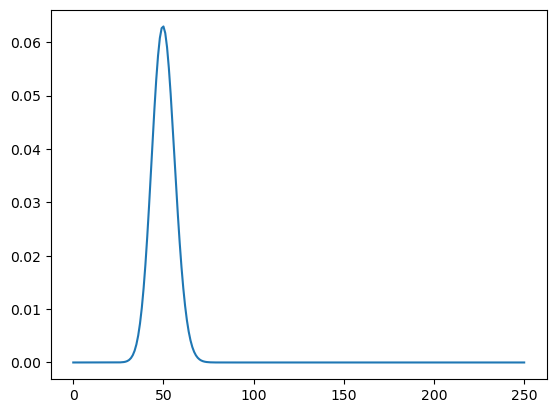

In [25]:
pmf_k = make_binomial(250, 0.2)
plt.plot(pmf_k.qs, pmf_k.ps)

In [26]:
# recover the highest probability
pmf_k.max_prob()

50

Now try to repeat using the updating mechanism, and the machinery of Bayes

Prepare a uniform prior on the parameter that defines your 'coin' or the probability that any patient you pick in the hospital will be discharged tomorrow.

The key point below is that the **prior** is the probability assigned to each hypothesis (`hypos` in the code snippet). 

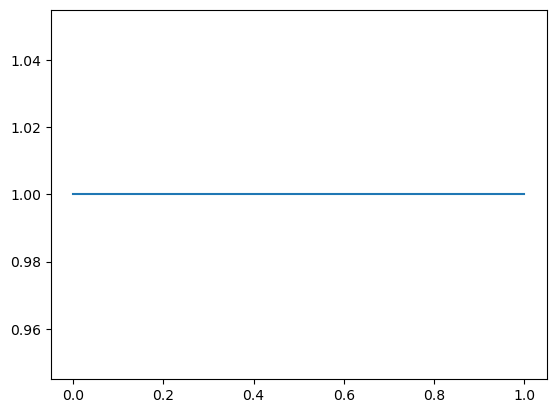

In [44]:
hypos = np.linspace(0, 1, 101) # hypos = hypotheses
prior = Pmf(1, hypos)
plt.plot(prior) # conveniently uses the index of the series for the 'x'

Now use the hypotheses to return the likelihood. Remember the likelihood is the probability of the data given each hypothesis. Here we have 101 possible hypotheses, and we observe **1** discharge (initially). We are therefore asking what the chance of observing a discharge is given each hypothesis. 

Pay attention because we are using the hypothesis (`hypos`) not the prior.

1. Starting with the hypothesis that the parameter _is_ 0 (i.e. the patient will not be discharged) then the likelihood of observing a discharge with that hypothesis must be 0. [Equivalent to a trick coin with two tails]
2. Now hypothesising that the parameter _is_ 1 (the patient will be discharged) then the likelihood of observing a discharge given _that_ hypothesis must be 1. [Equivalent to a trick coin with two heads]
3. And extending this then when the hypothesis _is_ 0.01, 0.02, ... then the likelihood of observing a discharge given that hypothesis must also be 0.01, 0.02, ... [Equivalent to biased or weighted coins]

The likelihood defined below returns the probability of the data (i.e. the observation aka the observed events; in this case either a discharge or a non-discharge). But here we introduce a _parameter_ that controls this probability. We are using a 'coin' and the notion of whether the coin is fair is controlled by that _parameter_. 

The mental leap that we make here is from the 'bowls' (chocolate cookies) problem. 
- 2 bowls then the likelihood is mechanically 0.5 if the bowl contains 50% chocolate cookies; and 0.75 if it contains 75%.
- 101 bowls then the likeliood is $0.00, 0.01, 0.02 ... 0.99, 1.00$ depending on the bowl.

Here we are imagining there are 101 different discharge statuses (or coin types), and we wish to know which discharge status (or coin type) we happen to be working with.

In [24]:

# prob of discharge given the hypotheses
likelihood_discharge = hypos
# prob of not being discharged given the hypotheses
likelihood_inpatient = 1 - hypos 

# wrapped into a dictionary
likelihood = {
    'D': likelihood_discharge,
    'I': likelihood_inpatient
}


Now we start to watch the discharges to see if there's a problem with our assumption that the discharge rate is around 20%. We take our list of patients from yesterday and then start to check to see if they've gone home or not.

Patient 1 is still an inpatient.

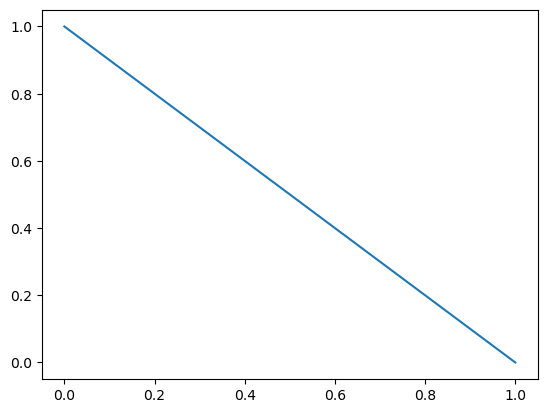

In [32]:
posterior = prior * likelihood['I']
plt.plot(posterior)

The updated probability distribution makes sense. It assigns zero chance to the discharge rate being 100% because we have now seen one failed discharge. The most likely hypothesis is that the discharge rate is 0% but it could be anything from 0 to 99%. So we don't know much more.

Let's keep going.

Patient 2 also did not get discharged.

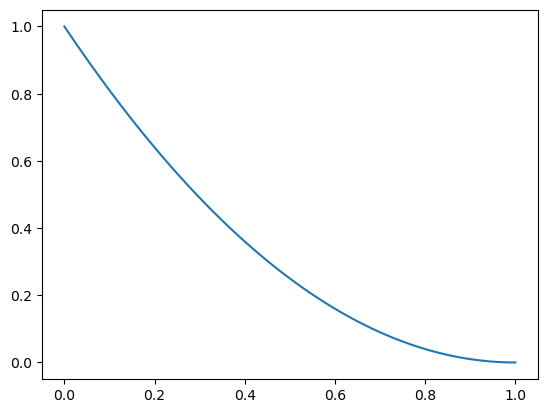

In [33]:
# the former posterior now becomes the prior
prior = posterior.copy()
posterior = prior * likelihood['I']
plt.plot(posterior)

Continuing our checks then patients 3, 4 and 5 also did not get discharged but patient 6 was discharged.

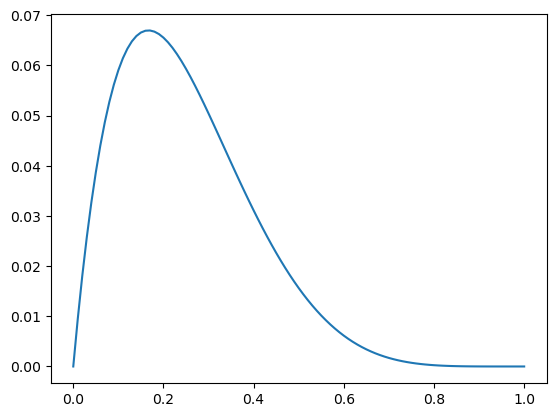

In [34]:
# patient 3
# using the previous posterior as the new prior
posterior = posterior  * likelihood['I']
# patient 4
posterior = posterior  * likelihood['I']
# patient 5
posterior = posterior  * likelihood['I']
# patient 6
posterior = posterior  * likelihood['D'] # <- discharge!!
plt.plot(posterior)


Let's wrap this up into a slightly more efficient piece of code

0 0 I
0 1 I
0 2 I
1 0 I
1 1 I
1 2 D
2 0 I
2 1 I
2 2 I


<Figure size 1000x700 with 0 Axes>

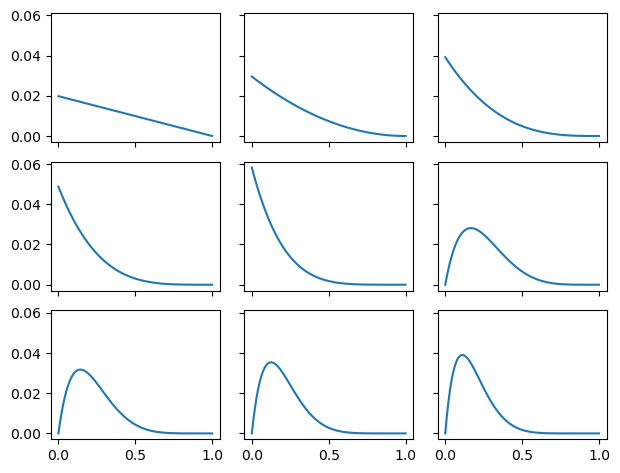

In [49]:
fig = plt.figure(figsize=(10, 7))
rows = 3
cols = 3
fig, ax = plt.subplots(rows, cols, sharex=True, sharey=True)

prior = Pmf(1, hypos)
discharges = "IIIIIDIII" # 8 inpatients, 1 discharge
posterior = prior.copy()
for row in range(rows):
    for col in range(cols):
        patient = discharges[(row * cols) + col]
        print(row, col, patient)
        posterior = posterior * likelihood[patient]
        posterior.normalize() # scale by dividing by total unscaled
        ax[row, col].plot(posterior)
fig.tight_layout()

2022-09-27 | work in progress | next steps


- work with a coarser grid or build an example to make it clear that we're sneaking up on the continuous distributions from a discrete
- repeat the above using a the binomial rather than multiplying each time (diachronic)
- work with different priors (triangle etc.)

Notes from ThinkBayes

> The other difference is the nature of what we are estimating. In the 101 Bowls Problem, we choose the bowl randomly, so it is uncontroversial to compute the probability of choosing each bowl. In the Euro Problem, the proportion of heads is a physical property of a given coin. Under some interpretations of probability, that’s a problem because physical properties are not considered random.

- Downey, Allen B.. Think Bayes (p. 61). O'Reilly Media. Kindle Edition. 